In [1]:
%load_ext autoreload
%autoreload 2

## Libraries

In [12]:
import numpy as np
import pandas as pd
from pathlib import Path
from src.utils import *
from src.preprocessing import *
from src.visualization import *
from src.categorical_feature_selectors import MutualInformationSelector
from src.correlation_feature_selector import CorrelationFeatureSelector

In [13]:
root_dir = Path("data").resolve()
filename = 'train.csv'

In [14]:
X  = read_data_from_csv(root_dir, filename).drop(columns=["Id"])
y = X["SalePrice"]

In [16]:
n_df = X[get_numeric_columns(X)]

In [17]:
for col in columns_with_nans(n_df).index:
    n_df = feature_fill_nan_with_value(n_df, col, n_df[col].mean())

In [18]:
n_df = CorrelationFeatureSelector(method='spearman', threshold=0.2).fit_transform(n_df, y)

In [19]:
n_df = n_df.drop(columns='SalePrice')

In [20]:
c_df = X[get_categorical_columns(X)]

In [21]:
c_df = fill_nan(c_df, "NA")

In [22]:
c_df = MutualInformationSelector(mi_threshold=0.1).fit_transform(c_df, y)

## Concat filtered features

In [23]:
# X_preprocessed, _ = normalize_data(pd.concat([n_df, c_df], axis=1).to_numpy())
X_preprocessed = pd.concat([n_df, c_df], axis=1).to_numpy()

In [24]:
X_train, X_test, y_train, y_test = split_data(X_preprocessed, log_transform(y), test_size=0.3, shuffle=True)
X_train, scalar = normalize_data(X_train)
X_test = scalar.transform(X_test)

In [25]:
from sklearn.dummy import DummyRegressor

In [26]:
dummy_model = DummyRegressor(strategy='mean').fit(X_train, y=y_train)

In [27]:
y_preds = dummy_model.predict(X_test)

In [28]:
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_preds)
rmse = root_mean_squared_error(y_test, y_preds)
r2  = r2_score(y_test, y_preds)

In [29]:
print(mse, rmse, r2)

0.16990443027764138 0.412194650957095 -0.001535501621115376


In [30]:
import numpy as np
import matplotlib.pyplot as plt

def plot_with_error_shading(y_true, y_pred, ax=None):
    # Sort by true values for a cleaner plot (optional)
    if ax is None:
        fig, ax = plt.subplots()
    sorted_idx = np.argsort(y_true)
    y_true_sorted = np.array(y_true)[sorted_idx]
    y_pred_sorted = np.array(y_pred)[sorted_idx]

    ax.plot(y_true_sorted, label='Actual', color='red')
    ax.plot(y_pred_sorted, label='Predicted', color='blue')

    # Shaded area: absolute error
    ax.fill_between(range(len(y_true)), y_true_sorted, y_pred_sorted,
                     color='green', alpha=0.3, label='Error (Residual)')

    ax.set_title('Actual vs Predicted with Error Shading')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Target Value')
    ax.legend()
    ax.grid(True)


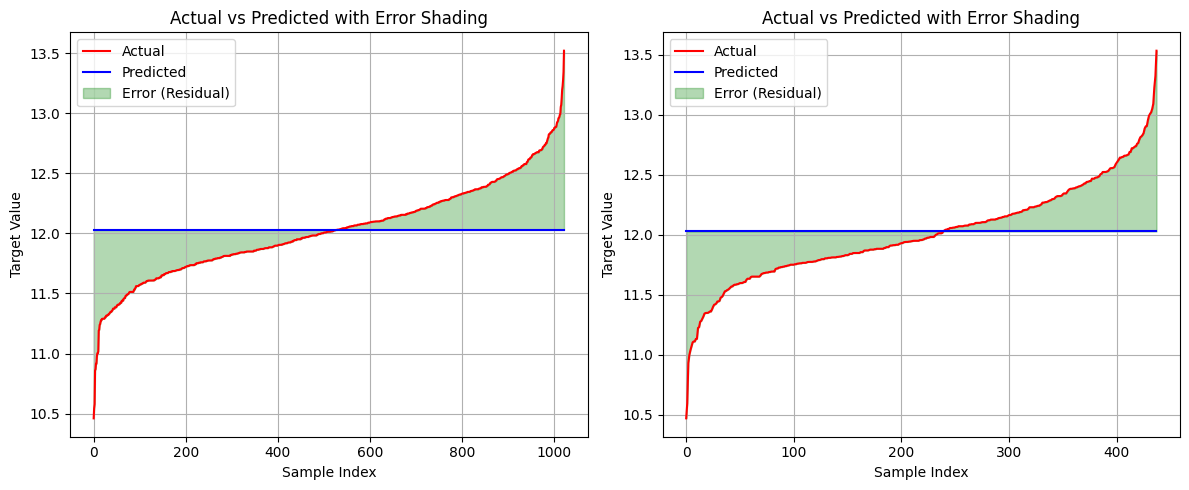

In [31]:
fig, axes = plt.subplots(1, 2,figsize=(12, 5))  # 1 row, 2 columns
plot_with_error_shading(y_train, dummy_model.predict(X_train), ax=axes[0])
plot_with_error_shading(y_test, y_preds, ax=axes[1])
plt.tight_layout()
plt.show()

In [32]:
from sklearn.svm import SVR

In [33]:
model = SVR(kernel='linear', C=0.001, max_iter=100000, epsilon=0.01)

In [34]:
model.fit(X_train, y_train)

SVR(C=0.001, epsilon=0.01, kernel='linear', max_iter=100000)

In [35]:
y_preds = model.predict(X_test)

In [36]:
mse = mean_squared_error(y_test, y_preds)
rmse = root_mean_squared_error(y_test, y_preds)
r2  = r2_score(y_test, y_preds)

In [37]:
print(mse, rmse, r2)

0.02136923670988244 0.14618220380703817 0.8740347784191425


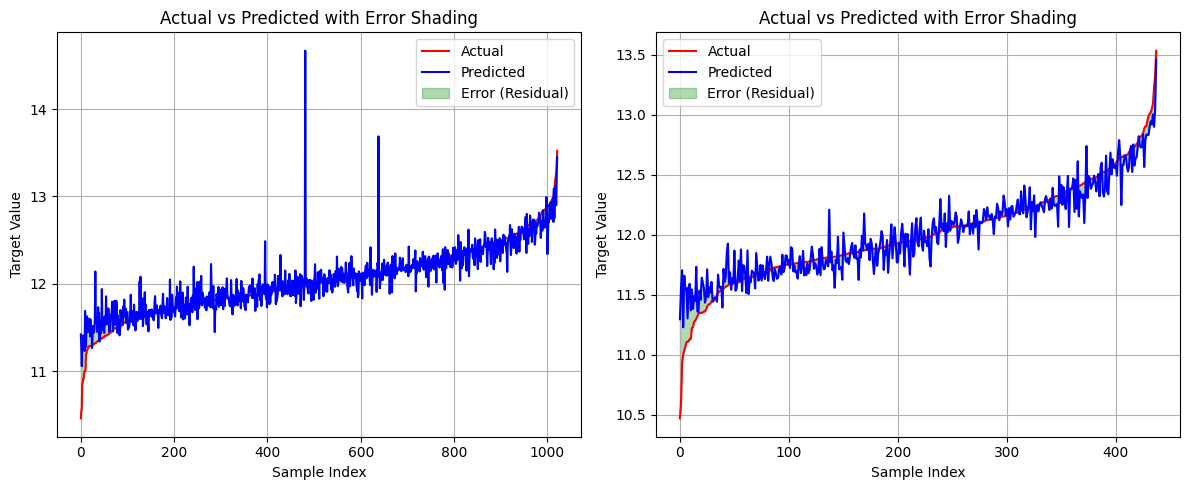

In [38]:
fig, axes = plt.subplots(1, 2,figsize=(12, 5))  # 1 row, 2 columns
plot_with_error_shading(y_train, model.predict(X_train), ax=axes[0])
plot_with_error_shading(y_test, y_preds, ax=axes[1])
plt.tight_layout()
plt.show()

In [39]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=300,
                      random_state=42)

In [40]:
y_preds = rf.predict(X_test)

In [41]:
mse = mean_squared_error(y_test, y_preds)
rmse = root_mean_squared_error(y_test, y_preds)
r2  = r2_score(y_test, y_preds)

In [42]:
print(mse, rmse, r2)

0.020284189498166266 0.14242257369590772 0.88043080530139


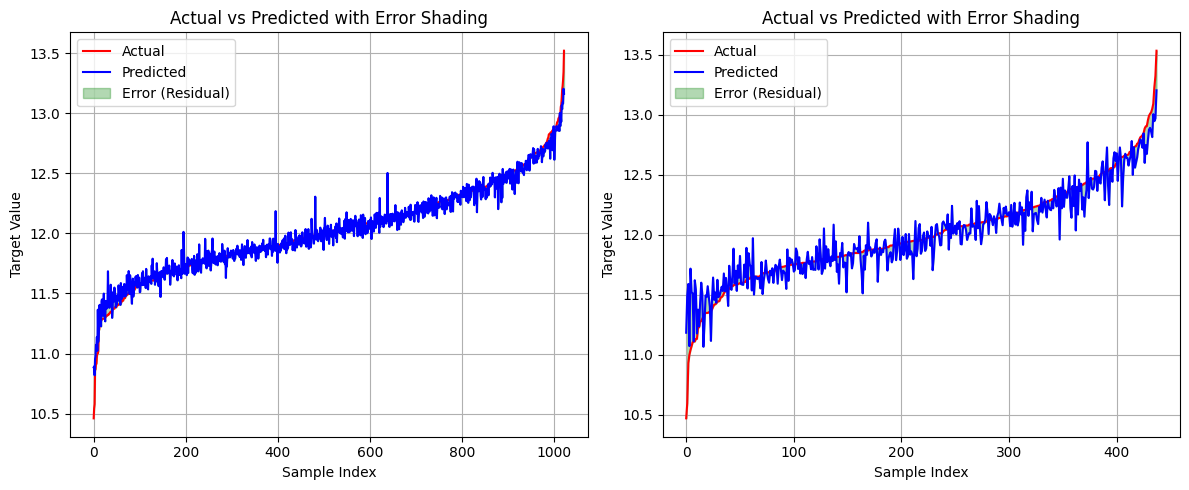

In [43]:
fig, axes = plt.subplots(1, 2,figsize=(12, 5))  # 1 row, 2 columns
plot_with_error_shading(y_train, rf.predict(X_train), ax=axes[0])
plot_with_error_shading(y_test, y_preds, ax=axes[1])
plt.tight_layout()
plt.show()

In [54]:
# Or LightGBM
import lightgbm as lgb
model = lgb.LGBMRegressor(
    n_estimators=120,
    learning_rate=0.07,
    num_leaves=16,
    random_state=42
)

In [46]:
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2540
[LightGBM] [Info] Number of data points in the train set: 1022, number of used features: 36
[LightGBM] [Info] Start training from score 12.028899


LGBMRegressor(learning_rate=0.07, n_estimators=120, num_leaves=16,
              random_state=42)

In [ ]:
y_preds = model.predict(X_test)

/home/sarieh2/miniconda3/envs/kaggle_house/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [ ]:
mse = mean_squared_error(y_test, model.predict(X_test))
rmse = root_mean_squared_error(y_test, model.predict(X_test))
r2  = r2_score(y_test, model.predict(X_test))

print(mse, rmse, r2)

0.0209575916789648 0.14476737090575625 0.876461302035132


/home/sarieh2/miniconda3/envs/kaggle_house/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sarieh2/miniconda3/envs/kaggle_house/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sarieh2/miniconda3/envs/kaggle_house/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/home/sarieh2/miniconda3/envs/kaggle_house/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


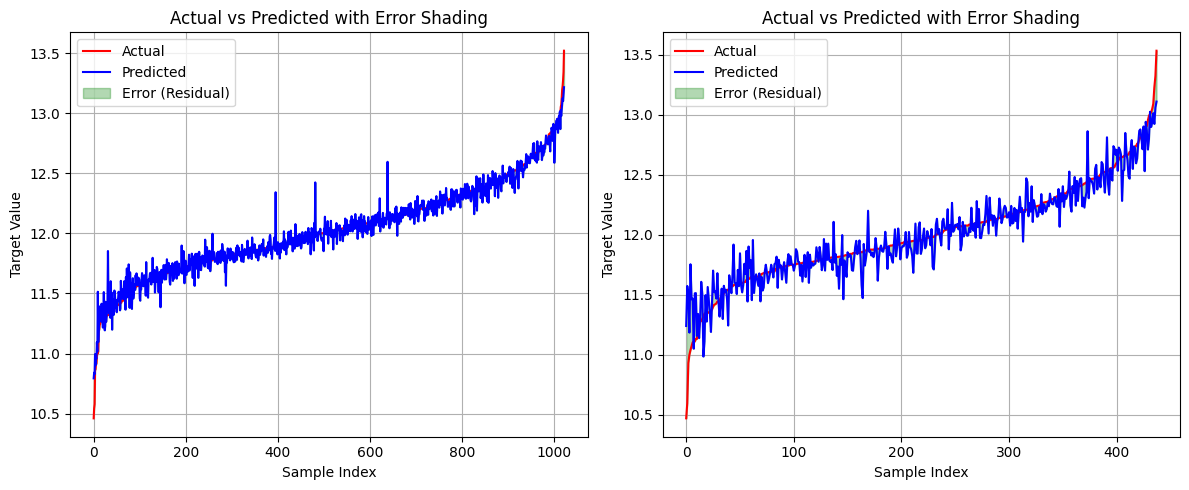

In [50]:
fig, axes = plt.subplots(1, 2,figsize=(12, 5))  # 1 row, 2 columns
plot_with_error_shading(y_train, model.predict(X_train), ax=axes[0])
plot_with_error_shading(y_test, y_preds, ax=axes[1])
plt.tight_layout()
plt.show()